In [4]:
import torch
import numpy as np 
import matplotlib.pyplot as plt
import glob,pickle,os,copy,sys,random,time
from scipy.spatial import ConvexHull
from scipy.spatial import Delaunay
#goal reach distance is 4, effective load is 1
def get_ground_truth(gd,gd_next):
    traj=[gd[0,:2]]
    for i in range(gd.shape[0]-1):
        if (gd_next[i,:]==gd[i+1,:]).all():
            traj.append(gd[i+1,:2])
        else:
            traj.append(gd_next[i,:2])
            traj.append(gd[i+1,:2])
    traj.append(gd_next[-1,:2])
    return np.array(traj)
def gen_init_state(init_mu,init_sigma,run_idx):
    np.random.seed(run_idx)
    if run_idx==0:
        init=init_mu
        return init
    else:
        init=np.random.normal(init_mu,init_sigma)
        return init
def in_hull(p,H1,H2):
    if H1.find_simplex(p)>=0 and H2.find_simplex(p)<0:
        return True
    else:
        return False
loccc='Downloads/t42_hand'
model_path='/Users/zsbjltwjj/'+loccc+'/zs_sim_robot/trans_model_data/real_ah_wm_v0.1/model_lr0.0002_val0.1_seed0_nn_2_dp_0.1_nodes_200_epochs_10'
norm_path='/Users/zsbjltwjj/'+loccc+'/zs_sim_robot/trans_model_data/real_ah_wm_v0.1/normalization/normalization_arr'
#norm_path='/Users/zsbjltwjj/'+loccc+'/zs_sim_robot/trans_model_data/real_ah_avi/normalization/normalization_arr'
#norm_path='/Users/zsbjltwjj/'+loccc+'/zs_sim_robot/trans_model_data/real_ah_nm_v1.6/normalization/normalization_arr'
goal_path='/Users/zsbjltwjj/Downloads/t42_hand/t42_control/rollout_t42/set/goals.png'
set_path='/Users/zsbjltwjj/Downloads/t42_hand/t42_control/rollout_t42/set/astar_set/'
set_mode='astar'

#if not os.path.exists(set_path):
#    os.makedirs(set_path)
if not os.path.exists(set_path):
    os.makedirs(set_path)
with open(model_path, 'rb') as pickle_file:
    model = torch.load(pickle_file, map_location='cpu')
with open(norm_path, 'rb') as pickle_file:
    x_norm_arr, y_norm_arr = pickle.load(pickle_file)
    x_mean_arr, x_std_arr = x_norm_arr[0], x_norm_arr[1]
    y_mean_arr, y_std_arr = y_norm_arr[0], y_norm_arr[1]
    init_mu=x_mean_arr[-4:]
    init_sigma=x_std_arr[-4:]
print(init_mu,init_sigma)

[  19.74210739  108.40126038   80.96710205 -102.52011108] [2.47281098 0.44119838 5.34786844 2.73469996]


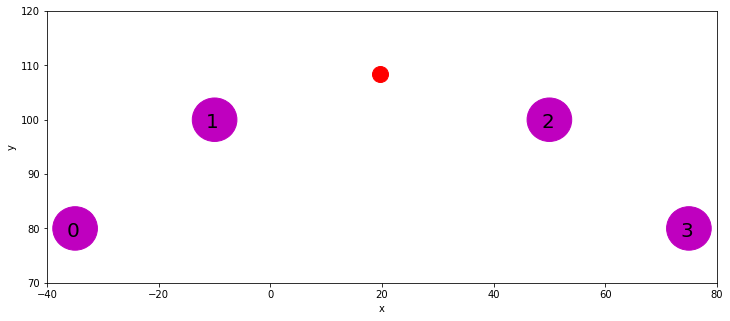

In [55]:
Goal = np.array([[-35, 80],[-10, 100],[50, 100], [75, 80]])
fig, ax = plt.subplots(figsize=(12,5))
inx = [0,1,2,3]
for i in inx:
    ctr = Goal[i]
    goal_plan = plt.Circle((ctr[0], ctr[1]), 4., color='m')
    ax.add_artist(goal_plan)
    plt.text(ctr[0]-1.5, ctr[1]-1.5, str(i), fontsize=20) 
plt.plot(init_mu[0],init_mu[1], 'o', markersize=16, color ='r')
plt.xlim([-40, 80])
#plt.xlim([-60, 120])
plt.ylim([70, 120])
#plt.ylim([50, 120])
plt.xlabel('x')
plt.ylabel('y')
plt.savefig(goal_path, dpi=200)

In [56]:
def normalize(data,x_std_arr,x_mean_arr):
    return (data - x_mean_arr[:data.shape[-1]]) / x_std_arr[:data.shape[-1]]
def denormalize(data,y_std_arr,y_mean_arr):
    return data * y_std_arr[:data.shape[-1]] + y_mean_arr[:data.shape[-1]]

def dist(start_loc,end_loc):
    return np.linalg.norm(end_loc-start_loc)
def calc_g(parent,child):
    return parent.g+dist(parent.loc,child.loc)
def calc_step(parent,child):
    return parent.step+1
def calc_h(child,goal_loc):
    return dist(child.loc,goal_loc)

def priority_sort(f_fringe):
    index=np.random.choice(np.argwhere(f_fringe==np.min(f_fringe)).reshape(-1),1)[0]
    return index

def mstep_predict(num_steps,state,init_state,ac,model,x_std_arr,x_mean_arr,y_std_arr,y_mean_arr):
    next_state_arr=np.empty((0,4))
    for i in range(num_steps):
        sa=np.concatenate([state,ac,init_state])
        inpt = normalize(sa,x_std_arr,x_mean_arr)
        inpt = torch.tensor(inpt, dtype=torch.float)
        state_delta = model(inpt)    
        state_delta = state_delta.detach().numpy()
        state_delta = denormalize(state_delta,y_std_arr,y_mean_arr)
        next_state= sa[:4] + state_delta
        next_state_arr=np.concatenate((next_state_arr,next_state.reshape(1,4)),axis=0)
        state=next_state
    return next_state, next_state_arr

class mnode(object):
    def __init__(self,ac_weight,state,init_state,num_steps,state_h):
        self.num_steps=num_steps
        self.ac_weight=ac_weight
        self.state=state
        self.loc=state[:2]
        self.load=state[2:]
        self.init_state=init_state
        self.state_h=state_h
        self.prev=None
        self.g=0
        self.ng=0
        self.step=0
        self.f=0
        self.action=np.repeat(np.array([0,0]).reshape(1,2),num_steps,axis=0)
    def add_prev(self,prev_node,action):
        self.prev=prev_node
        self.g=calc_g(prev_node,self)
        self.ng=0
        self.step=calc_step(prev_node,self)
        self.action=np.repeat(action.reshape(1,2),self.num_steps,axis=0)
    def calc_f(self,h,action,goal_loc,mode=''):
        w_turnover=0
        self.f=self.g+1000*w_turnover
        self.f=self.f+h
        w_ac=0
        if (action==np.array([1,1])).all() or (action==np.array([-1,-1])).all():
            w_ac=1
        self.f=self.f+self.ac_weight*w_ac
        #self.f=self.ng+h
        #self.f=self.step+h
def mstep_isvalid(child,goal_loc,big_goal_radius,init_x_loc):
    if not ((np.abs(child.state_h[:,2:])>=1).all() and (np.abs(child.state_h[:,2:])<=280).all()): 
        return False
    elif (child.state_h[-1,0]-init_x_loc)*(goal_loc[0]-init_x_loc)<=0:
        return False
    else:
        return True

    
def Astar_discrete_mstep_stomodel(ac_weight,num_steps,initial_state,goal_loc,model,x_std_arr,x_mean_arr,y_std_arr,y_mean_arr,big_goal_radius=4.,mode=''):
    actions=[np.array([-1,1]),np.array([1,-1]),np.array([1,1]),np.array([-1,-1]),np.array([0,1]),np.array([1,0]),np.array([0,-1]),np.array([-1,0])]
    
    initial=mnode(ac_weight,initial_state,initial_state,num_steps,np.repeat(initial_state.reshape(1,4),num_steps,axis=0))
    fringe=[initial]
    state_fringe=[initial.state]
    f_fringe=[initial.f]
    state_closed_set=[]
    
    max_size_fringe=1
    num_expanded_nodes=0
    tstart=time.time()
    print_times=0
    pt_first=True
    while len(fringe)!=0:
        index=priority_sort(f_fringe)
        state_fringe.pop(index)
        f_fringe.pop(index)
        cur=fringe.pop(index)
        #print(calc_h(cur,goal_loc))
        #print(len(f_fringe))
        #print(cur.f)
        #print(cur.action[-1,:])
        
        tm=time.time()-tstart
        if tm>=360000:
            break
        elif tm>=print_times*600:
            print_times+=1
            print(cur.step)
            print(cur.f)
            #print(cur.action)
            #print(cur.f-cur.g)
            #print(cur.f-cur.ng)
            #print(cur.f-cur.step)
        if state_closed_set==[] or not np.any(np.all(np.isin(np.array(state_closed_set),cur.state,True),axis=1)):
            if (np.linalg.norm(goal_loc-cur.state_h[:,:2],axis=1)<=0.6875*big_goal_radius).any():
                print(cur.f)
                idx=np.argwhere((np.linalg.norm(goal_loc-cur.state_h[:,:2],axis=1)<=0.6875*big_goal_radius)==True)[0][0]
                cur_path=copy.copy(cur)
                path=[cur_path.state_h[:idx+1,:]]
                action_path=[cur_path.action[:idx+1,:]]
                while cur_path.prev != None:
                    path.insert(0,cur_path.prev.state_h)
                    action_path.insert(0,cur_path.prev.action)
                    cur_path=cur_path.prev
                action_path.pop(0)
                path[0]=path[0][:1,:]
                total_time=time.time()-tstart
                return "success", np.concatenate(path,axis=0), np.concatenate(action_path,axis=0),len(action_path), num_expanded_nodes, max_size_fringe, total_time
            else:#start expanding
                num_expanded_nodes+=1
                j=1
                for i in actions:
                    child_state,child_state_h=mstep_predict(num_steps,cur.state,initial_state,i,model,x_std_arr,x_mean_arr,y_std_arr,y_mean_arr)
                    child=mnode(ac_weight,child_state,initial_state,num_steps,child_state_h)
                    if mstep_isvalid(child,goal_loc,big_goal_radius,initial.loc[0]):
                        if state_closed_set==[] or not np.any(np.all(np.isin(np.array(state_closed_set),child.state,True),axis=1)):
                            if state_fringe==[] or not np.any(np.all(np.isin(np.array(state_fringe),child.state,True),axis=1)):
                                fringe.append(child)
                                child.add_prev(cur,i)
                                child.calc_f(calc_h(child, goal_loc),i,goal_loc,mode)
                                state_fringe.append(child.state)
                                f_fringe.append(child.f)
                                j+=1
                if len(fringe)>max_size_fringe:
                    max_size_fringe=len(fringe)
            state_closed_set.append(cur.state)
    total_time=time.time()-tstart
    return "failure", None, None, None, num_expanded_nodes, max_size_fringe, total_time

def mplot_planned_traj(num_steps,set_mode,set_path,initial_state,run_idx,goal_idx,plan_path,goal_loc,big_goal_radius=4.):
    fig, ax = plt.subplots(figsize=(10,3))
    goal_plan = plt.Circle((goal_loc[0], goal_loc[1]), big_goal_radius, color='m')
    ax.add_artist(goal_plan)
    plt.text(goal_loc[0]-1.5, goal_loc[1]-1.5, str(goal_idx), fontsize=20)
    plt.plot(initial_state[0], initial_state[1], 'ok', markersize=16, color ='r')
    if plan_path is not None:
        plt.plot(plan_path[:,0],plan_path[:,1],'-k')
    plt.xlim([-40, 80])
    #plt.xlim([-60, 120])
    plt.ylim([70, 120])
    #plt.ylim([50, 120])
    plt.xlabel('x')
    plt.ylabel('y')
    plt.savefig(set_path+set_mode+'_goal'+str(goal_idx)+'_run'+str(run_idx)+'_m'+str(num_steps)+'.png', dpi=200)

0
0
64.23580196544357
len_of_action:  10
num_expanded_nodes:  50


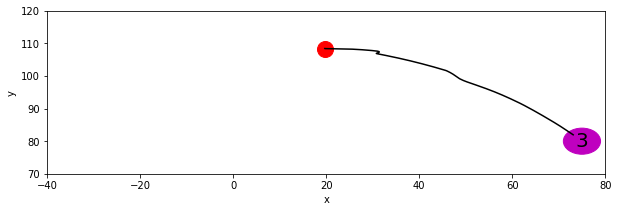

In [85]:
big_goal_radius=4.
ac_weight=10000
run_idx=0
set_path='/Users/zsbjltwjj/Downloads/t42_hand/t42_control/rollout_t42/set/astar_set/'
if not os.path.exists(set_path):
    os.makedirs(set_path)
#for goal_idx in [0,1,2,3]:
for goal_idx in [3]:
    num_steps=100
    initial_state=gen_init_state(init_mu,init_sigma,run_idx)
    goal_loc=Goal[goal_idx]
    status, plan_path, plan_action_path,len_action_path, num_expanded_nodes, max_size_fringe, total_time\
    =Astar_discrete_mstep_stomodel(ac_weight,num_steps,initial_state,goal_loc,model,x_std_arr,x_mean_arr,y_std_arr,y_mean_arr,big_goal_radius=big_goal_radius,mode='')
    print('len_of_action: ',len_action_path)
    print('num_expanded_nodes: ', num_expanded_nodes)
    np.savetxt(set_path+set_mode+'_goal'+str(goal_idx)+'_run'+str(run_idx)+'_m'+str(num_steps)+'_traj.txt',\
               plan_path, fmt='%.20f', delimiter=',')
    np.savetxt(set_path+set_mode+'_goal'+str(goal_idx)+'_run'+str(run_idx)+'_m'+str(num_steps)+'_plan.txt',\
               plan_action_path, fmt='%.20f', delimiter=',')
    mplot_planned_traj(num_steps,set_mode,set_path,initial_state,run_idx,goal_idx,plan_path,goal_loc,big_goal_radius=big_goal_radius)

In [86]:
plan_action_path.shape

(975, 2)

In [100]:
plan_action_path[900,:]

array([ 0, -1])

In [1]:
import numpy as np

In [8]:
a=np.ones(2)
b=a

In [9]:
b=np.array([2,2])
a

array([1., 1.])

In [17]:
class a(object):
    def __init__(self,w=0):
        self.w=w

In [19]:
ass=a(0)
if not (ass.w and ass.c):
    print('asds')

asds
